In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 as cv
import matplotlib.pyplot as plt
from keras.preprocessing import image
from PIL import Image
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input,decode_predictions
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.layers import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import load_model
import os
import threading
tf.random.set_seed(2)
np.random.seed(1)


In [ ]:
InputPath="/bin/download.jpeg"

Python version
3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


In [ ]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.0001
        sigma = var**0.05
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy =  gauss + image
        return noisy
    elif noise_typ == "s&p":
        row, col, ch = image.shape
        print(row, col)  # add this line to check the size of the input image
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 1.0
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(image.size * s_vs_p)
        coords = [np.random.randint(0, i, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i , int(num_pepper))
              for i in image.shape]
        out[coords] = 1
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

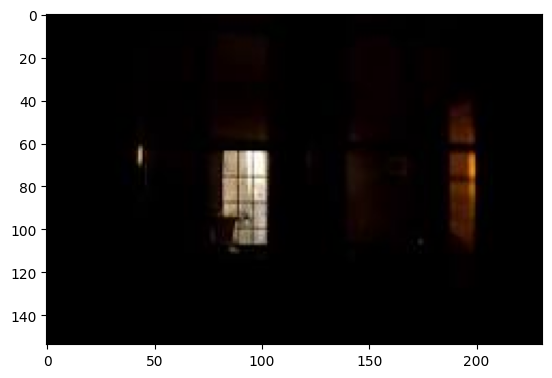

In [ ]:
img = cv.imread(InputPath)  
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
l = img.max()
plt.imshow(img)


154 231


<ipython-input-3-c0d2ef2e7641>:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-3-c0d2ef2e7641>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


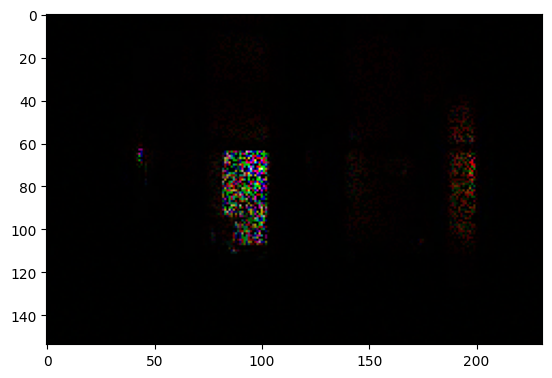

In [ ]:
Noise = noisy("s&p",img)
plt.imshow(Noise)

154 231


<ipython-input-3-c0d2ef2e7641>:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-3-c0d2ef2e7641>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


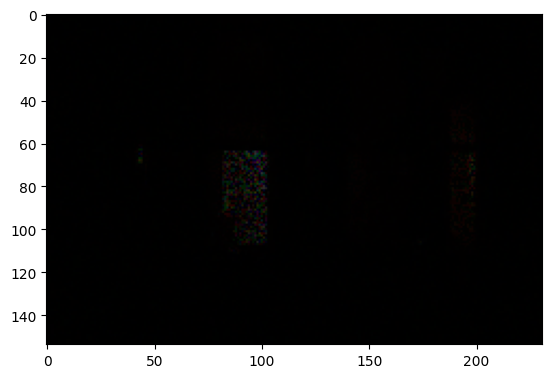

In [ ]:
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV) #convert it to hsv
hsv[...,2] = hsv[...,2]*0.2
img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
Noise2 = noisy("s&p",img1)

plt.imshow(Noise2)

In [ ]:
def PreProcessData(ImagePath):
    X_=[]
    y_=[]
    count=0
    for imageDir in os.listdir(ImagePath):
        if count<2131:
            try:
                count=count+1
                img = cv.imread(ImagePath + imageDir)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img_y = cv.resize(img,(500,500))
                hsv = cv.cvtColor(img_y, cv.COLOR_BGR2HSV) #convert it to hsv
                hsv[...,2] = hsv[...,2]*0.2
                img_1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
                Noisey_img = noisy("s&p",img_1)
                X_.append(Noisey_img)
                y_.append(img_y)
            except:
                pass
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_,y_

In [ ]:
X_,y_ = PreProcessData("/bin/")

500 500


<ipython-input-3-c0d2ef2e7641>:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-3-c0d2ef2e7641>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


500 500
500 500
500 500


In [ ]:
K.clear_session()
def InstantiateModel(in_):
    
    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)
    
    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_add = add([model_1,model_2,model_2_0])
    
    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)
    
    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)
    
    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)
    
    model_add_2 = add([model_3_1,model_3_2,model_3])
    
    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)
    #Extension
    model_add_3 = add([model_4_1,model_add_2,model_4])
    
    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)
    
    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)
    
    return model_5

In [ ]:
Input_Sample = Input(shape=(500, 500,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)

In [ ]:
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 500, 500, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 500, 500, 32  896         ['input_1[0][0]']                
                                )                                                             

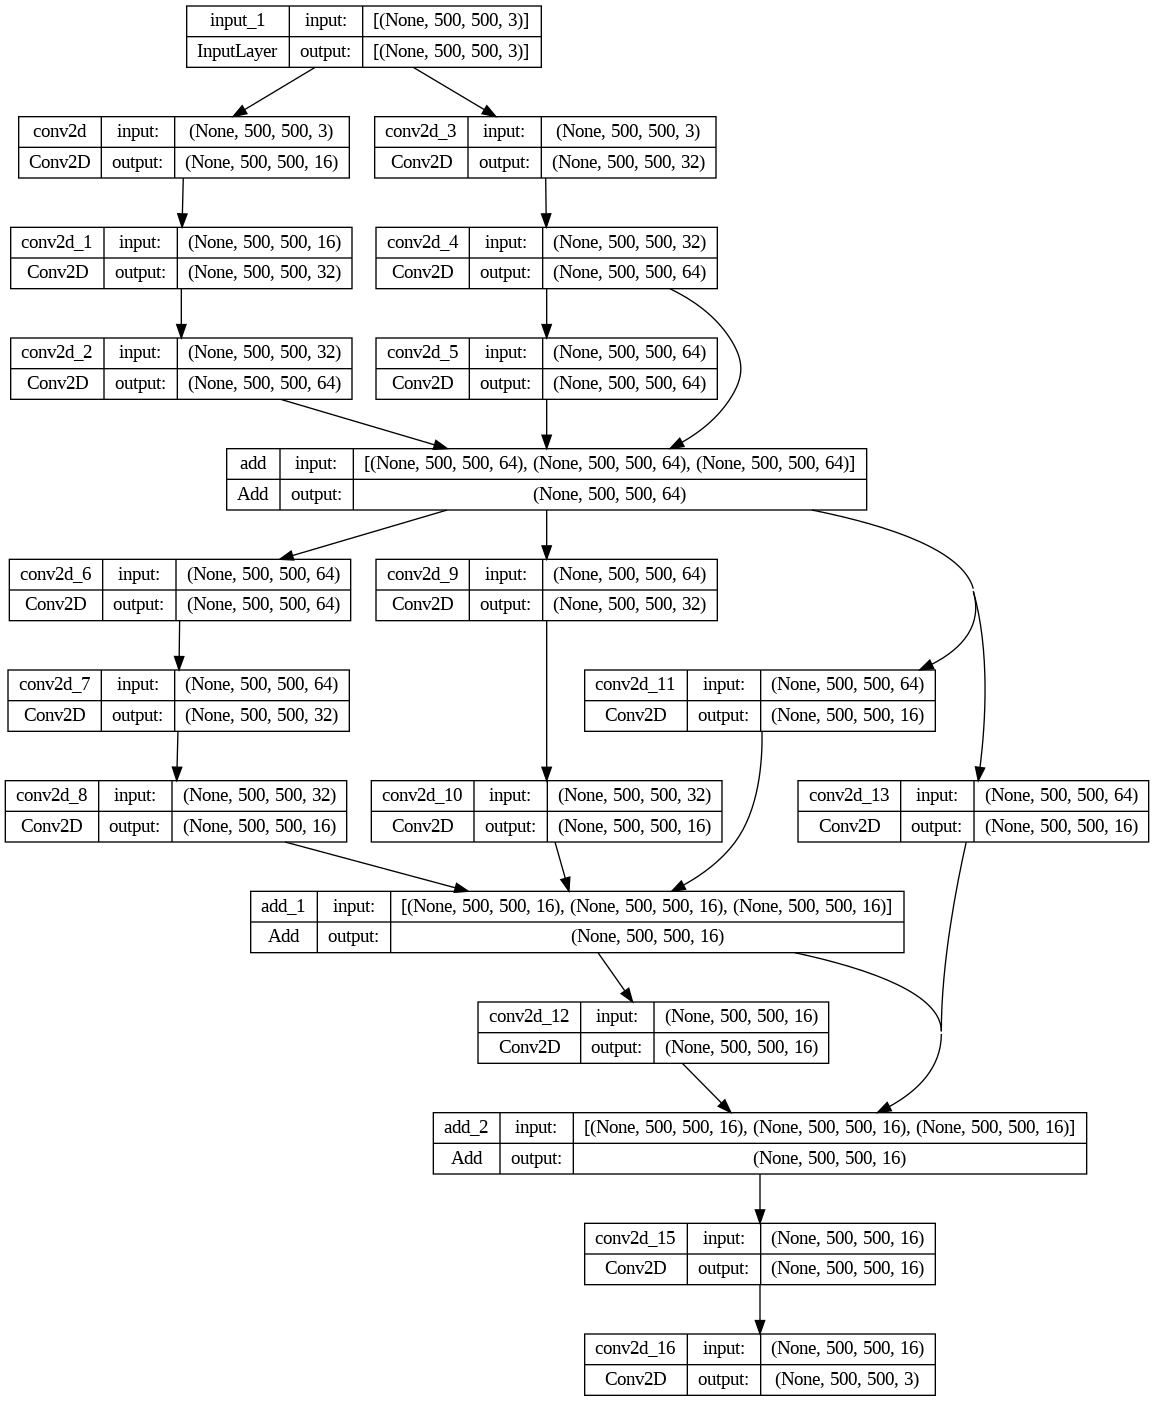

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(Model_Enhancer,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [ ]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
Model_Enhancer.fit_generator(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=39,shuffle=True)

In [ ]:
TestPath="/bin/download.jpeg"

In [ ]:
def ExtractTestInput(ImagePath):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_ = cv.resize(img,(500,500))
    hsv = cv.cvtColor(img_, cv.COLOR_BGR2HSV) #convert it to hsv
    hsv[...,2] = hsv[...,2]*0.2
    img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    Noise = noisy("s&p",img1)
    Noise = Noise.reshape(1,500,500,3)
    return Noise

In [ ]:
ImagePath=TestPath
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)

500 500
1/1 [==============================] - 2s 2s/step


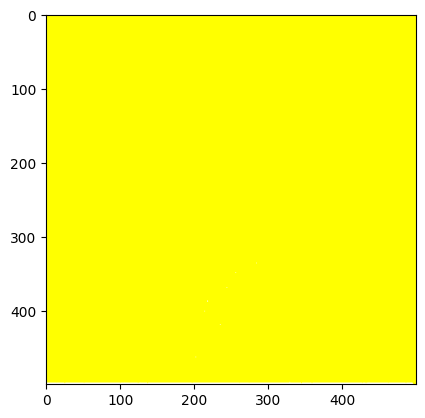

In [ ]:
Prediction = Prediction.reshape(500,500,3)
plt.imshow(Prediction)

In [ ]:
%mkdir templates -p
%mkdir static -p

In [ ]:
%%writefile static/style.css
body {
    margin: 0;
    font-family: Arial, sans-serif;
    background-color: #f1f1f1;
}

header {
    background-color: #333;
    color: #fff;
    padding: 20px;
    text-align: center;
    width: 100%;
    z-index: 1000;
  }
  
  header h1 {
    margin: 0;
    font-size: 24px;
    text-transform: uppercase;
    letter-spacing: 2px;
  }

nav {
    display: flex;
    justify-content: space-around;
    align-items: center;
    background-color: #333;
    color: #fff;
    padding: 10px 20px;
}

nav a {
    color: #fff;
    text-decoration: none;
    font-size: 18px;
    transition: background-color 0.2s;
}

nav a:hover {
    background-color: #444;
}

main {
    display: flex;
    flex-direction: column;
    align-items: center;
    padding: 20px;
}

form {
    display: flex;
    flex-direction: column;
    align-items: center;
    width: 60%;
    max-width: 500px;
    margin: 20px auto;
    background-color: #fff;
    border-radius: 10px;
    box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
    padding: 20px;
}

input[type="file"] {
    margin: 20px 0;
    padding: 10px;
    font-size: 16px;
    border: 1px solid #ccc;
    border-radius: 4px;
    background-color: #f1f1f1;
}

button[type="button"] {
    margin: 20px 0;
    padding: 10px 20px;
    font-size: 16px;
    border: none;
    border-radius: 4px;
    background-color: #333;
    color: #fff;
    transition: background-color 0.2s;
}

button[type="button"]:hover {
    background-color: #444;
}

#output {
    display: flex;
    justify-content: space-around;
    align-items: center;
    width: 80%;
    margin: 20px 0;
}

#output img {
    width: 30%;
    
    border-radius: 10px;
    box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
}

footer {
    background-color: #333;
    color: #fff;
    padding: 20px;
    text-align: center;
    position: fixed;
    bottom: 0;
    width: 100%;
  }
  
  footer p {
    margin: 0;
    font-size: 14px;
    text-transform: uppercase;
    letter-spacing: 2px;
  }

@media (max-width: 600px) {
    nav {
        flex-direction: column;
    }

    nav a {
        margin: 10px 0;
    }

    form {
        width: 80%;
    }

    #output {
        flex-direction: column
    }

    #output img {
        width: 80%;
        margin: 10px 0;
    }
}

@media (max-width: 400px) {
    header h1 {
        font-size: 20px;
    }

    nav a {
        font-size: 16px;
    }
}

Writing static/style.css


In [ ]:
%%writefile templates/index.html

<!DOCTYPE html>
<html>

<head>
    <title>Low Light Image Enhancement</title>
    <link rel="stylesheet" type="text/css" href="{{ url_for('static', filename='style.css') }}">
</head>

<body>
    <header>
        <h1>Low Light Image Enhancement</h1>
    </header>
    <nav>
        <a href="#">Home</a>
        <a href="#">About</a>
        <a href="#">Contact</a>
    </nav>
    <main>
        <h2>Upload Your Image</h2>
        <form action="{{ url_for('enhance') }}" method="POST" enctype="multipart/form-data">
            <input type="file" id="input-image" name="myImage" accept="image/x-png,image/jpg,image/jpeg"  required="required"/>
            <input type="submit" value="Enhance" name="action1"/>
        </form>
        {% if result %}
        <div id="output">
            <!-- {% if original_image is defined %} -->
            <h3>Original Image</h3>
            <img id="original-image" src="{{ url_for('static', filename=original_image) }}" width="400" height="400">

            <!-- {% endif %} -->
            <!-- {% if enhanced_image is defined %} -->
            <h3>Enhanced Image</h3>
            <img id="enhanced-image" src="{{ url_for('static', filename=enhanced_image) }}" width="400" height="400">
            <br>
           <button id="done-btn1" style="display: none;">Download</button>
            <!-- {% endif %} -->
        </div>
        {% endif %}
    </main>
    <script>
        
        function download() 
        { 
           const doneBtn1 = document.getElementById('done-btn1');
           doneBtn1.style.display = 'block';
           doneBtn1.addEventListener('click', (event) => {
           event.preventDefault();
           const url = '/download';
           const link = document.createElement('a');
        link.href = url;
        link.download = 'enhanced_image.png';
        document.body.appendChild(link);
        link.click();
        document.body.removeChild(link);
      });

   
                
        }
        download();
    
    </script>
</body>

</html> 

Writing templates/index.html


In [ ]:
!pip install pyngrok
!pip install flask_ngrok

# !lsof -i :5000

# !kill 125


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=cbe5259bc93115114585bb6d71b91fac568613b43e2ef656aa28a11ee770bf21
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from flask_ngrok import run_with_ngrok
from pyngrok import ngrok
ngrok.set_auth_token("2QdxFlNxBUoV4IsKeN5DVdfhKnk_2oSnRxhqT27h5dr9f8Zbx")
public_url=ngrok.connect(5000).public_url

In [12]:

from flask import Flask,render_template, request, send_file
from pyngrok import ngrok
from flask_ngrok import run_with_ngrok

app=Flask(__name__)
run_with_ngrok(app)

app.config["BASE_URL"] =public_url

model = load_model("./model_for_all.h5")
@app.route('/')
def home():
    return render_template('index.html')


@app.route('/enhance', methods=['POST'])
def enhance():
    # Open the uploaded image and apply image enhancement techniques
    image = Image.open(request.files['myImage'])
    gt_image_file="gt_image.png"
    %mkdir static -p
    path="./static/"
    image.save(path+gt_image_file)

    test_image=path + gt_image_file
    img_ = ExtractTestInput(test_image)
    Prediction = model.predict(img_)
    img_ = img_.reshape(500,500,3)
    low_image_file="low_image.png"
    cv.imwrite(path+low_image_file,img_)

    
    Prediction = Prediction.reshape(500,500,3)
    img_[:,:,:] = Prediction[:,:,:]
    
    img = np.array(img_)
    enhanced_image_file = "enhanced_image.png"
    cv.imwrite(path+enhanced_image_file,img_)
    result=True
    return render_template('index.html', result=result, original_image= gt_image_file, enhanced_image= enhanced_image_file)


@app.route('/download')
def download():
    file = './static/enhanced_image.png'
    return send_file(file, as_attachment=True)

app.run()




 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://9d4b-34-125-79-205.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:40:41] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:40:42] "GET /static/style.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:40:43] "GET /favicon.ico HTTP/1.1" 404 -


500 500


<ipython-input-4-c0d2ef2e7641>:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-4-c0d2ef2e7641>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


1/1 [==============================] - 2s 2s/step


INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:40:54] "POST /enhance HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:40:55] "GET /static/style.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:40:55] "GET /static/gt_image.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:40:55] "GET /static/enhanced_image.png HTTP/1.1" 200 -


500 500
1/1 [==============================] - 2s 2s/step


INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:41:21] "POST /enhance HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:41:21] "GET /static/style.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:41:21] "GET /static/gt_image.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:41:21] "GET /static/enhanced_image.png HTTP/1.1" 200 -


500 500
1/1 [==============================] - 2s 2s/step


INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:41:45] "POST /enhance HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:41:45] "GET /static/style.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:41:45] "GET /static/gt_image.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:41:46] "GET /static/enhanced_image.png HTTP/1.1" 200 -


500 500
1/1 [==============================] - 2s 2s/step


INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:42:09] "POST /enhance HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:42:10] "GET /static/style.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:42:10] "GET /static/gt_image.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jun/2023 12:42:10] "GET /static/enhanced_image.png HTTP/1.1" 200 -


500 500


<ipython-input-4-c0d2ef2e7641>:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-4-c0d2ef2e7641>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


1/1 [==============================] - 2s 2s/step


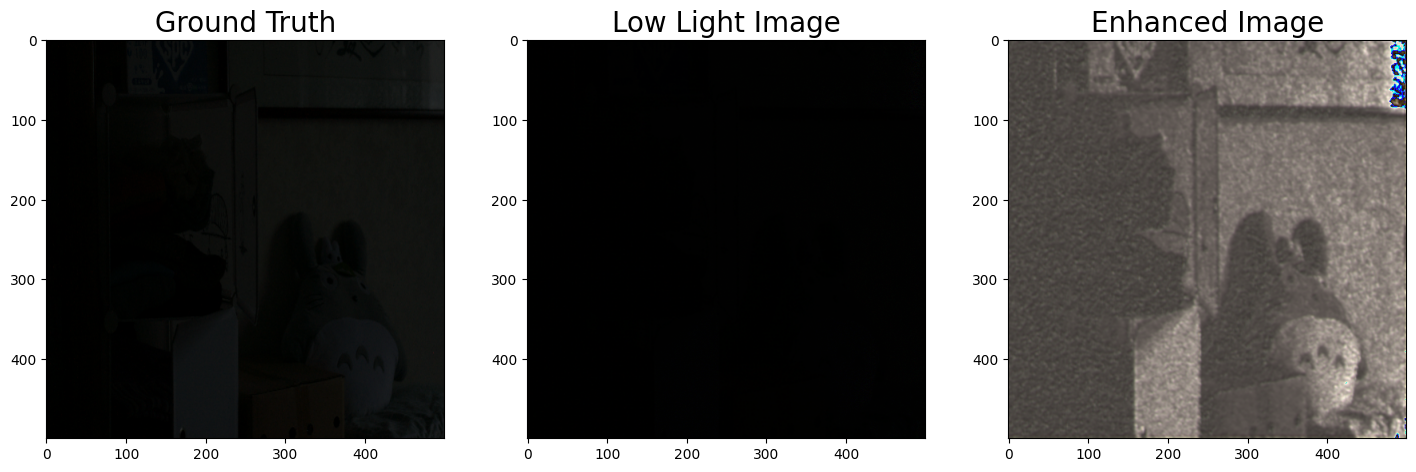

In [11]:
#testing the model
from keras.models import load_model
Image_test2="/bin/23.png"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Model_Enhancer = load_model("/bin/model_for_all.h5")
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

500 500


<ipython-input-4-c0d2ef2e7641>:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-4-c0d2ef2e7641>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


1/1 [==============================] - 2s 2s/step


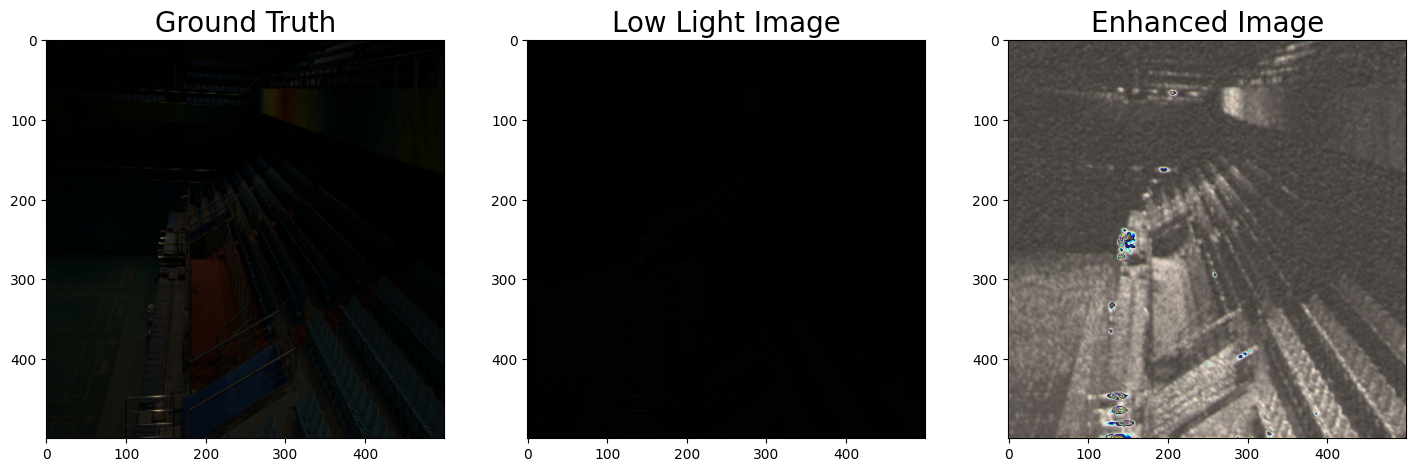

In [21]:
Image_test2="/bin/778.png"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Model_Enhancer = load_model("/bin/model_for_all.h5")
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

500 500


<ipython-input-4-c0d2ef2e7641>:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-4-c0d2ef2e7641>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


1/1 [==============================] - 2s 2s/step


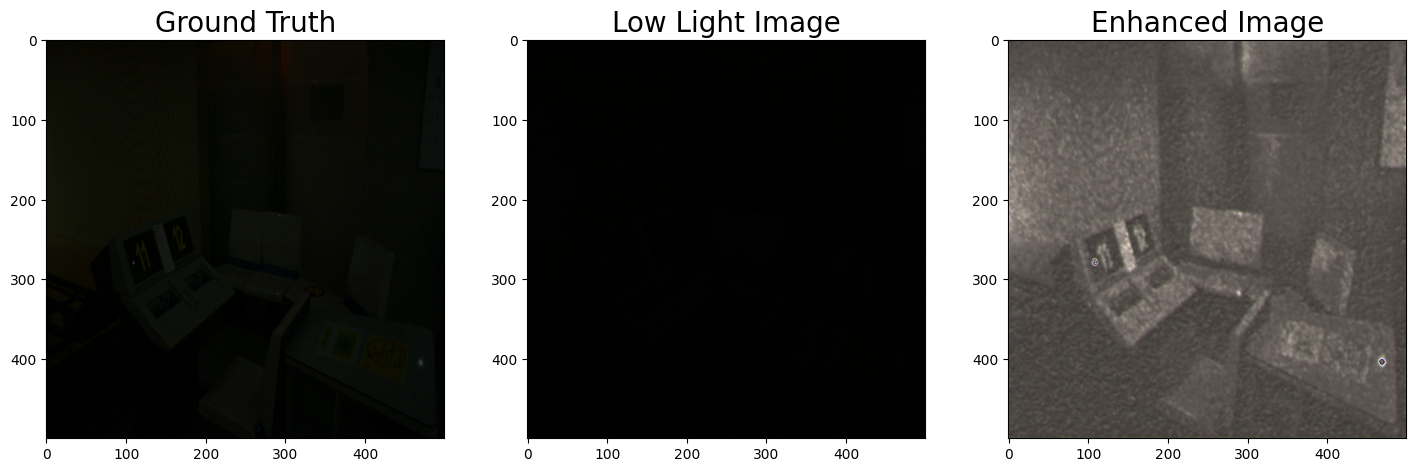

In [13]:
Image_test2="/bin/665.png"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Model_Enhancer = load_model("/bin/model_for_all.h5")
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

500 500


<ipython-input-4-c0d2ef2e7641>:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-4-c0d2ef2e7641>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


1/1 [==============================] - 2s 2s/step


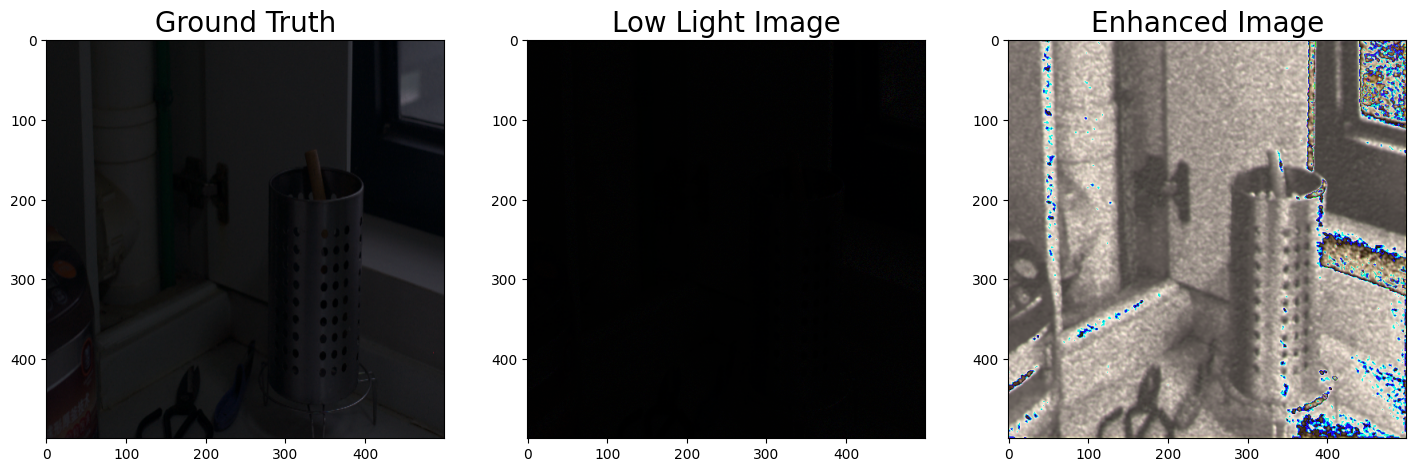

In [23]:
Image_test2="/bin/111.png"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Model_Enhancer = load_model("/bin/model_for_all.h5")
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)